In [17]:
from itertools import product
import pandas as pd
import seaborn as sns

## Recovery with addm_toolbox.ddm_mla_test

In [2]:
from __future__ import absolute_import

import argparse

from addm_toolbox.ddm_mla_test import wrap_ddm_get_model_log_likelihood

In [3]:
d = .006
sigma = .08
rangeD = [0.005, 0.006, 0.007]
rangeSigma = [0.065, 0.08, 0.095]

In [4]:
def main(d, sigma, rangeD, rangeSigma, trialsFileName=None, numTrials=10,
         numSimulations=10, binStep=100, maxRT=8000, numThreads=9,
         verbose=False):
    """
    Args:
      d: float, DDM parameter for generating artificial data.
      sigma: float, DDM parameter for generating artificial data.
      rangeD: list of floats, search range for parameter d.
      rangeSigma: list of floats, search range for parameter sigma.
      trialsFileName: string, path of trial conditions file.
      numTrials: int, number of artificial data trials to be generated per
          trial condition.
      numSimulations: int, number of simulations to be generated per trial
          condition, to be used in the RT histograms.
      binStep: int, size of the bin step to be used in the RT histograms.
      maxRT: int, maximum RT to be used in the RT histograms.
      numThreads: int, size of the thread pool.
      verbose: boolean, whether or not to increase output verbosity.
    """
    pool = Pool(numThreads)

    histBins = list(range(0, maxRT + binStep, binStep))

    # Load trial conditions.
    if not trialsFileName:
        trialsFileName = pkg_resources.resource_filename(
            u"addm_toolbox", u"test_data/test_trial_conditions.csv")
    trialConditions = load_trial_conditions_from_csv(trialsFileName)

    # Generate artificial data.
    dataRTLeft = dict()
    dataRTRight = dict()
    for trialCondition in trialConditions:
        dataRTLeft[trialCondition] = list()
        dataRTRight[trialCondition] = list()
    model = DDM(d, sigma)
    for trialCondition in trialConditions:
        t = 0
        while t < numTrials:
            try:
                trial = model.simulate_trial(
                    trialCondition[0], trialCondition[1])
            except:
                print(u"An exception occurred while generating artificial "
                      "trial " + str(t) + u" for condition " +
                      str(trialCondition[0]) + u", " + str(trialCondition[1]) +
                      u".")
                raise
            if trial.choice == -1:
                dataRTLeft[trialCondition].append(trial.RT)
            elif trial.choice == 1:
                dataRTRight[trialCondition].append(trial.RT)
            t += 1

    # Generate histograms for artificial data.
    dataHistLeft = dict()
    dataHistRight = dict()
    for trialCondition in trialConditions:
        dataHistLeft[trialCondition] = np.histogram(
            dataRTLeft[trialCondition], bins=histBins)[0]
        dataHistRight[trialCondition] = np.histogram(
            dataRTRight[trialCondition], bins=histBins)[0]

    # Grid search on the parameters of the model.
    if verbose:
        print(u"Performing grid search over the model parameters...")
    listParams = list()
    models = list()
    for d in rangeD:
        for sigma in rangeSigma:
            model = DDM(d, sigma)
            models.append(model)
            listParams.append((model, trialConditions, numSimulations,
                              histBins, dataHistLeft, dataHistRight))
    logLikelihoods = pool.map(wrap_ddm_get_model_log_likelihood, listParams)
    pool.close()

    if verbose:
        for i, model in enumerate(models):
            print(u"L" + str(model.params) + u" = " + str(logLikelihoods[i]))
        bestIndex = logLikelihoods.index(max(logLikelihoods))
        print(u"Best fit: " + str(models[bestIndex].params))

    return dataRTLeft, dataRTRight, dataHistLeft, dataHistRight, models, logLikelihoods

In [7]:
from __future__ import absolute_import

import numpy as np
import pkg_resources

from builtins import range, str
from multiprocessing import Pool

from addm_toolbox.ddm_mla import DDM
from addm_toolbox.util import load_trial_conditions_from_csv

In [23]:
dataRTLeft, dataRTRight, dataHistLeft, dataHistRight, models, logLikelihoods = main(d, sigma, rangeD, rangeSigma, trialsFileName=None, numTrials=50, 
                                                                                    numSimulations=10, binStep=100, maxRT=8000, numThreads=9, verbose=False)

In [24]:
df = pd.DataFrame(list(product(rangeD, rangeSigma)), columns=['d', 'sigma'])
df['logLikelihood'] = logLikelihoods
df

,d,sigma,logLikelihood
0,0.005,0.065,-258.311998
1,0.005,0.080,-269.515184
2,0.005,0.095,-307.190848
3,0.006,0.065,-261.607628
4,0.006,0.080,-191.068579
5,0.006,0.095,-264.332426
6,0.007,0.065,-306.083701
7,0.007,0.080,-337.480965
8,0.007,0.095,-293.151613


<AxesSubplot:xlabel='sigma', ylabel='d'>

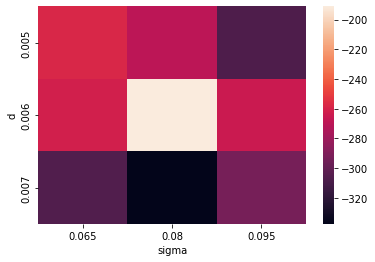

In [25]:
df = df.pivot(index = 'd', columns = 'sigma', values = 'logLikelihood')
sns.heatmap(df)

In [26]:
dataRTLeft

{(0.0, 0.0): [1290,
  2180,
  1050,
  3400,
  2320,
  2370,
  790,
  410,
  240,
  1420,
  1360,
  2700,
  650,
  2210,
  2090,
  1380,
  840,
  1800,
  1530,
  310,
  2880,
  1600,
  4340,
  1120,
  5750,
  1120,
  510,
  650,
  290],
 (0.0, 1.0): [1320, 1010, 2740, 1180, 1280, 280, 1070, 780, 4680, 3190, 430],
 (0.0, 2.0): [],
 (0.0, 3.0): [560],
 (1.0, 1.0): [4580,
  370,
  750,
  880,
  1850,
  3270,
  2280,
  220,
  3010,
  1010,
  940,
  2370,
  1470,
  3110,
  5020,
  800,
  900,
  760,
  620,
  2360,
  2080,
  3050,
  2090],
 (1.0, 2.0): [1820, 230, 2260, 3530, 340, 900, 3000, 510],
 (1.0, 3.0): [],
 (2.0, 2.0): [3310,
  2300,
  2350,
  1460,
  1790,
  540,
  1220,
  1700,
  1760,
  140,
  1000,
  1090,
  1440,
  1640,
  2640,
  1410,
  2190,
  6350,
  1560,
  2740,
  1250,
  2600,
  530,
  1700,
  3460,
  3720,
  900],
 (2.0, 3.0): [1660, 920, 2040, 710, 420, 650, 940, 1340],
 (3.0, 3.0): [940,
  1090,
  540,
  450,
  700,
  4420,
  4020,
  1660,
  980,
  2060,
  1130,
  550,


In [16]:
dataHistLeft

{(0.0,
  0.0): array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (0.0,
  1.0): array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (0.0,
  2.0): array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (0.0,
  3.0): array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0